# Test effect of sample qualiy on accuracy

We previously established the best kmer size and training parameters. Here we will test the effects of sample quality. He we will read the fastp file to retrieve insert size and an estimator of DNA damage. This estimator will be the covariance between frequency of T and base position in read 1 between bases 10 and 20. DNA damage causes C to T transitions, and these are increased towards the end of the read. We start counting at base 10 since composition is unstable at the 5' end due to other reasons and we do it until base 20 to guarantee this is independent of total read length.

In [1]:
from functions import *
import warnings, os, json
warnings.filterwarnings('ignore')

get_device_name(0)

'Tesla V100-PCIE-32GB'

Let's read json files and assemble sample quality statistics.

In [2]:
df = pd.read_csv('sample_info.csv')
df

,sample_number,species,collector,collection,country,dna_concentration,library_id,filename_root
0,1,S_paralias,Demuner,4839,Brazil,92.0,S-1,PREP0024_RAsprSUB09764A_B10v1_S-1
1,2,S_paralias,Machado,76247,Brazil,1.4,S-2,PREP0025_RAsprSUB09764A_E05v1_S-2
2,3,S_paralias,Amorim et al.,1533,Brazil,11.2,S-3,PREP0023_RAsprSUB09764A_A05v1_S-3
3,4,S_paralias,Andrade,321,Brazil,45.2,S-4,PREP0024_RAsprSUB09764A_G07v1_S-4
4,5,S_paralias,Anderson,13695,Brazil,1.36,S-5,PREP0025_RAsprSUB09764A_G05v1_S-5
...,...,...,...,...,...,...,...,...
95,96,S_bannisterioides,Webster & Wilson,5229,Jamaica,1.1,S-96,PREP0025_RAsprSUB09764A_D07v1_S-96
96,97,S_bannisterioides,Ventura A.,20404,Mexico,18.4,S-97,PREP0023_RAsprSUB09764A_E03v1_S-97
97,98,S_bannisterioides,Hahn,4814,Guyana,too high,S-98,PREP0024_RAsprSUB09764A_C03v1_S-98
98,99,S_bannisterioides,Fernandes EAC,20118,"Brazil, Ceará",too high,S-99,PREP0023_RAsprSUB09764A_A04v1_S-99


In [3]:
def get_stats(libid):
    json_file = [x for x in (Path('intermediate_files')/'clean_reads').glob('*+' + libid + '_*.json')][0]
    js = json.load(open(json_file,'r'))
    ins = js['insert_size']['histogram']
    ave_insert = sum(np.array(ins) * np.array(range(len(ins))))/sum(ins)
    content = np.array([x for k,x in js['merged_and_filtered']['content_curves'].items() if k in ['A','T','C','G']])
    content_sd = np.std(content[:,20:50], axis = 1).mean()
    return({'insert_size':ave_insert, 'content_sd':content_sd})

In [4]:
df = pd.concat([df, pd.DataFrame(df['library_id'].apply(get_stats).tolist())],1).sort_values('content_sd')
df.to_csv('sample_info_stats.csv')
df

,sample_number,species,collector,collection,country,dna_concentration,library_id,filename_root,insert_size,content_sd
43,44,S_ellipticum,Pendry,934,Mexico,too high,S-44,PREP0024_RAsprSUB09764A_D01v1_S-44,173.874036,0.000661
31,32,S_bonariense,Hatschbach,51921,Brazil,66.4,S-32,PREP0024_RAsprSUB09764A_G12v1_S-32,147.103700,0.000691
47,48,S_ellipticum,Rosales,520,El Salvador,40.0,S-48,PREP0024_RAsprSUB09764A_G08v1_S-48,163.354988,0.000700
24,25,S_jatrophifolium,Anderson,12371,Argentina,86.4,S-25,PREP0024_RAsprSUB09764A_A12v1_S-25,152.058587,0.000701
49,50,S_ellipticum,MacDougal,634GR,Guatemala,too high,S-50,PREP0024_RAsprSUB09764A_G05v1_S-50,160.355665,0.000714
...,...,...,...,...,...,...,...,...,...,...
15,16,S_ciliatum,Harley et al.,18016,Brazil,0.136,S-16,PREP0026_RAsprSUB09764A_H09v1_S-16,99.673551,0.025370
8,9,S_paralias,Harley et al.,19324,Brazil,0.140,S-9,PREP0026_RAsprSUB09764A_E09v1_S-9,92.776756,0.042912
55,56,S_emarginatum,Zanoni et al.,33306,Dominican Republic,0.100,S-56,PREP0026_RAsprSUB09764A_F11v1_S-56,151.228281,0.062919
17,18,S_ciliatum,Eiten & Eiten,7858,Brazil,0.0,S-18,PREP0026_RAsprSUB09764A_H12v1_S-18,108.061974,0.084780


<AxesSubplot:xlabel='insert_size', ylabel='content_sd'>

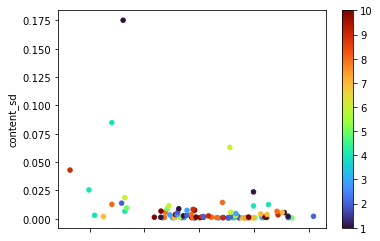

In [5]:
df.plot.scatter(x='insert_size',y='content_sd', c = df['species'].astype('category').cat.codes+1, cmap='turbo')

<AxesSubplot:ylabel='Frequency'>

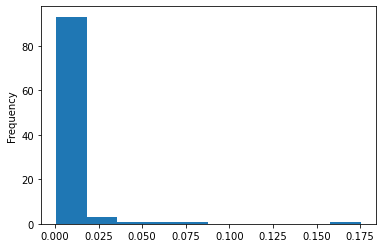

In [6]:
df['content_sd'].plot.hist()

In [7]:
pd.concat([df['species'].astype('category'),df['species'].astype('category').cat.codes+1],1).drop_duplicates()

,species,0
43,S_ellipticum,5
31,S_bonariense,3
24,S_jatrophifolium,7
59,S_emarginatum,6
91,S_bannisterioides,1
0,S_paralias,9
68,S_puberum,10
10,S_ciliatum,4
82,S_bogotense,2
76,S_lindenianum,8


It seems S. cilliatum  and S. bannisteroides have some of the lowest-quality libraries. Now we will test what happens when we include or exclude poor libraries from training. Let's mark which ones are these.

In [8]:
lowest_insert_size = df.sort_values('insert_size').groupby('species').head(4)['library_id']
highest_c_sd = df.sort_values('content_sd').groupby('species').tail(4)['library_id']

df

,sample_number,species,collector,collection,country,dna_concentration,library_id,filename_root,insert_size,content_sd
43,44,S_ellipticum,Pendry,934,Mexico,too high,S-44,PREP0024_RAsprSUB09764A_D01v1_S-44,173.874036,0.000661
31,32,S_bonariense,Hatschbach,51921,Brazil,66.4,S-32,PREP0024_RAsprSUB09764A_G12v1_S-32,147.103700,0.000691
47,48,S_ellipticum,Rosales,520,El Salvador,40.0,S-48,PREP0024_RAsprSUB09764A_G08v1_S-48,163.354988,0.000700
24,25,S_jatrophifolium,Anderson,12371,Argentina,86.4,S-25,PREP0024_RAsprSUB09764A_A12v1_S-25,152.058587,0.000701
49,50,S_ellipticum,MacDougal,634GR,Guatemala,too high,S-50,PREP0024_RAsprSUB09764A_G05v1_S-50,160.355665,0.000714
...,...,...,...,...,...,...,...,...,...,...
15,16,S_ciliatum,Harley et al.,18016,Brazil,0.136,S-16,PREP0026_RAsprSUB09764A_H09v1_S-16,99.673551,0.025370
8,9,S_paralias,Harley et al.,19324,Brazil,0.140,S-9,PREP0026_RAsprSUB09764A_E09v1_S-9,92.776756,0.042912
55,56,S_emarginatum,Zanoni et al.,33306,Dominican Republic,0.100,S-56,PREP0026_RAsprSUB09764A_F11v1_S-56,151.228281,0.062919
17,18,S_ciliatum,Eiten & Eiten,7858,Brazil,0.0,S-18,PREP0026_RAsprSUB09764A_H12v1_S-18,108.061974,0.084780


For each quality measure, let's now do the following: train the model with 5 samples per species, and check whether this model can correctly guess each of the other samples. These 5 species will consist from 0-3 lowest quality samples and the remaining of highest quality samples. We will repeat this 30 times for each combination o quality metric and number of low quality samples.


In [9]:
kmer_size = 7
all_bp_tr = [x*1e6 for x in [1,2,5,10,20,50,100,200]]

file_path = [x.absolute() for x in (Path('images_' + str(kmer_size))).ls() if x.suffix == '.png']
taxon = [x.name.split('+')[0] for x in file_path]
sample = [x.name.split('+')[-1].split('_')[0] for x in file_path]
n_bp = [int(x.name.split('_')[-1].split('.')[0].replace('K','000')) for x in file_path]

images = pd.DataFrame({'taxon': taxon,
              'sample': sample,
              'n_bp': n_bp,
              'path': file_path
             })

images = images.loc[images['n_bp'].isin(all_bp_tr)]

images['low_size'] = images['sample'].isin(lowest_insert_size)
images['high_c_sd'] = images['sample'].isin(highest_c_sd)
images

,taxon,sample,n_bp,path,low_size,high_c_sd
1,S_bannisterioides,S-100,200000000,/net/fs2k02/srv/export/farrell_lab/share_root/Bruno/working/CNN_spdelim/tests/species/images_7/S_bannisterioides+S-100_00200000K.png,False,True
2,S_bannisterioides,S-100,100000000,/net/fs2k02/srv/export/farrell_lab/share_root/Bruno/working/CNN_spdelim/tests/species/images_7/S_bannisterioides+S-100_00100000K.png,False,True
3,S_bannisterioides,S-100,50000000,/net/fs2k02/srv/export/farrell_lab/share_root/Bruno/working/CNN_spdelim/tests/species/images_7/S_bannisterioides+S-100_00050000K.png,False,True
4,S_bannisterioides,S-100,20000000,/net/fs2k02/srv/export/farrell_lab/share_root/Bruno/working/CNN_spdelim/tests/species/images_7/S_bannisterioides+S-100_00020000K.png,False,True
5,S_bannisterioides,S-100,10000000,/net/fs2k02/srv/export/farrell_lab/share_root/Bruno/working/CNN_spdelim/tests/species/images_7/S_bannisterioides+S-100_00010000K.png,False,True
...,...,...,...,...,...,...
985,S_puberum,S-70,20000000,/net/fs2k02/srv/export/farrell_lab/share_root/Bruno/working/CNN_spdelim/tests/species/images_7/S_puberum+S-70_00020000K.png,True,True
986,S_puberum,S-70,10000000,/net/fs2k02/srv/export/farrell_lab/share_root/Bruno/working/CNN_spdelim/tests/species/images_7/S_puberum+S-70_00010000K.png,True,True
987,S_puberum,S-70,5000000,/net/fs2k02/srv/export/farrell_lab/share_root/Bruno/working/CNN_spdelim/tests/species/images_7/S_puberum+S-70_00005000K.png,True,True
988,S_puberum,S-70,2000000,/net/fs2k02/srv/export/farrell_lab/share_root/Bruno/working/CNN_spdelim/tests/species/images_7/S_puberum+S-70_00002000K.png,True,True


Now that we defined functions, let's train the CNN while varying some parameters. Let's start by making a list containing the training conditions we want to test.

In [10]:
with open('sample_quality.txt','w') as outfile:
    for qual_metric in ['low_size', 'high_c_sd']:
        for n_lowqual in range(4):
            for replicate in range(30):
                clear_output()
                print('Metric',qual_metric)
                print('N low qual', n_lowqual)
                print('Replicate', replicate)
                include_lowqual = (images.
                                   loc[images[qual_metric],['taxon','sample']].
                                   drop_duplicates().
                                   groupby('taxon').
                                   sample(n_lowqual).
                                   loc[:,'sample']
                                  )
                include_highqual = (images.
                                   loc[~images[qual_metric],['taxon','sample']].
                                   drop_duplicates().
                                   groupby('taxon').
                                   sample(5 - n_lowqual).
                                   loc[:,'sample']
                                  )
                all_includes = pd.concat([include_highqual, include_lowqual])

                valid = images.loc[~images['sample'].isin(all_includes)].reset_index(drop=True).assign(is_valid = True)
                train = images.loc[images['sample'].isin(all_includes)].reset_index(drop=True).assign(is_valid = False)

                df = pd.concat([valid, train]).reset_index(drop = True)

                learn = train_cnn(df, 
                                  architecture = 'ig_resnext101_32x8d',
                                  pretrained = False,
                                  callbacks = CutMix,
                                  transforms = aug_transforms(do_flip = False,
                                                  max_rotate = 0,
                                                  max_zoom = 1,
                                                  max_lighting = 0.5,
                                                  max_warp = 0,
                                                  p_affine = 0,
                                                  p_lighting = 0.75
                                                 ),
                                  loss_fn = CrossEntropyLossFlat()
                                 )
                preds = get_predictions(learn, df, all_bp_tr)
                preds['lowqual'] = preds['sample'].isin(images.loc[images[qual_metric],'sample'].drop_duplicates())

                for i,x in preds.iterrows():

                    entry = dict(kmer_size=kmer_size,
                                 replicate = replicate,
                                 bp_training = '|'.join([str(x) for x in sorted(all_bp_tr)]),
                                 bp_valid = x['bp_valid'],
                                 samples_training = '|'.join(df.loc[~df['is_valid']]['sample'].drop_duplicates().sort_values().tolist()),
                                 n_samp_training = df.loc[~df['is_valid']]['sample'].drop_duplicates().shape[0],
                                 n_lowqual_training = n_lowqual,
                                 qual_metric = qual_metric,
                                 sample_valid = x['sample'],
                                 valid_actual = x['actual'],
                                 valid_prediction = x['prediction'],
                                 valid_lowqual = x['lowqual'])
                    print(entry, file = outfile)

print('DONE')
            

Metric high_c_sd
N low qual 3
Replicate 29


DONE


Now that we finished training and testing all models, let's save results as a table that can be easily read in R:

In [11]:
with open('sample_quality.txt','r') as infile:
    df = pd.DataFrame([eval(x) for x in infile])
    df.to_csv('sample_quality.csv')

Path('sample_quality.txt').unlink()

print('DONE')

DONE
